# Step 0: preliminary data wrangling and helper functions

In [1]:
# import everything we'll need here
import csv
import urllib.request
import pandas as pd
import io
import requests
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt 
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

# our mini library of general functions we'll use

def get_and_parse_old_style_data(_url, 
                                _station_dict=None):
    """
    There seem to be two styles of CSVs in the corpus. This function gets the old one and converts 
    to the new format which is far more readable. Then, if a dictionary is passed, it will join
    that datas so we know what station correspond to what turnstile. """

    data_as_dict = {}

    with requests.Session() as s:
        download = s.get(_url)
        decoded_content = download.content.decode('utf-8')

        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        my_list = list(cr)
        counter = 0

        for i, row in enumerate(my_list):
            ControlArea = row[0]
            UNIT = row[1]
            SCP = row[2]

            trunc_row = row[3:]

            for block in range((len(row)-3) // 5):
                start = block*5
                end = start+5

                new_row = [ControlArea, UNIT, SCP] + trunc_row[start:end]

                # annoying wuirk of the dataset with newlines not being parsed; ugly fix but it works
                if block == 7:
                    new_row[-1] = new_row[-1].strip()

                data_as_dict[counter] = new_row
                counter += 1

        data = pd.DataFrame.from_dict(data=data_as_dict, 
                                       columns=['C/A', 'UNIT', 'SCP','DATE', 'TIME', 
                                                'DESC', 'ENTRIES', 'EXITS'],
                                       orient='index')
        
        data['ENTRIES'] = pd.to_numeric(data['ENTRIES'])
        data['EXITS'] = pd.to_numeric(data['EXITS'])
        
        if _station_dict is not None:
            data['STATION'] = data['UNIT'].map(_station_dict)
        
        return data
    

def get_units_to_stations_mapping(_data):
    """
    Given a dataframe, return a dict of stations mapped to units"""
    
    units_to_stations = {}

    for unit in list(set(most_recent_data['UNIT'].values)):
        station = list(set(most_recent_data[most_recent_data['UNIT'] == unit]['STATION'].values))[0]
        units_to_stations[unit] = station
        
    return units_to_stations


def get_busyness(_url, 
                 _start_date,
                 _end_date, 
                 _next_date,
                 _group_by,
                 _final_group_by,
                 _old_style=True, 
                 _data=None):
    """ 
    Wrapping this in a function might make it a bit cleaner; same idea as above
    Computes busyness on a given date, grouping by cols specified"""
    
    if _data is not None:
        data = _data
        
    else:
        if _old_style:
            data = get_and_parse_old_style_data(_url=_url, 
                                                _station_dict=units_to_stations)

        else:
            content = requests.get(_url).content
            data = pd.read_csv(io.StringIO(content.decode('utf-8')))
            
    # a little goofy because the readings don't always take place at the same times; I've seen three types
    # and this accounts for 2 of the 3, which seem to be the majority. The other type is an irregular audit 
    # and occurs off the hour.
    EOD = data.loc[((data['TIME'] == '23:00:00') & (data['DATE'] == _end_date)) |
                  ((data['TIME'] == '00:00:00') & (data['DATE'] == _next_date))]

    SOD = data.loc[((data['TIME'] == '23:00:00') & (data['DATE'] == _start_date)) |
                  ((data['TIME'] == '00:00:00') & (data['DATE'] == _end_date))]
    
    # entries
    EOD_total_ENTRIES_by_station = EOD[['STATION', 'UNIT', 'SCP', 'ENTRIES']]\
                                        .groupby(_group_by)\
                                        .sum()
    SOD_total_ENTRIES_by_station = SOD[['STATION', 'UNIT', 'SCP', 'ENTRIES']]\
                                        .groupby(_group_by)\
                                        .sum()

    # exits
    EOD_total_EXITS_by_station = EOD[['STATION', 'UNIT', 'SCP', 'EXITS']]\
                                        .groupby(_group_by)\
                                        .sum()
    SOD_total_EXITS_by_station = SOD[['STATION', 'UNIT', 'SCP', 'EXITS']]\
                                        .groupby(_group_by)\
                                        .sum()

    total_ENTRIES_by_station = (EOD_total_ENTRIES_by_station - SOD_total_ENTRIES_by_station)
    total_ENTRIES_by_station = total_ENTRIES_by_station[total_ENTRIES_by_station > 0]

    total_EXITS_by_station = (EOD_total_EXITS_by_station - SOD_total_EXITS_by_station)
    total_EXITS_by_station = total_EXITS_by_station[total_EXITS_by_station > 0]
    
    busyness = pd.DataFrame((total_EXITS_by_station['EXITS']+total_ENTRIES_by_station['ENTRIES'])
                                 .groupby(_final_group_by)\
                                 .sum(),
                            columns = ['BUSYNESS'])\
                                 .sort_values(by='BUSYNESS', 
                                    ascending=False)

    return busyness

In [2]:
# getting all the csv URLs in one place

html = urlopen("http://web.mta.info/developers/turnstile.html") # Insert your URL to extract
beautiful_soup_obj = BeautifulSoup(html.read(), "lxml")
valid_csvs = []

for link in beautiful_soup_obj.find_all('a'):
    if """data/nyct/turnstile""" in str(link):
        valid_csvs.append(link.get('href'))

In [3]:
# get most recent data to validate it works

most_recent_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt'

content = requests.get(most_recent_url).content
most_recent_data = pd.read_csv(io.StringIO(content.decode('utf-8')))

most_recent_data.head(5)
print(most_recent_data.shape)

(203857, 11)


# Question 1: Which station has the most number of units?
## Answer: '23 ST'

In [4]:
# this seems like way too few? Or maybe my memory is failing. But I feel like there are several more 
# entry areas in GCT, in particular

most_recent_data[['UNIT', 'STATION']]\
    .groupby('STATION')[['UNIT']]\
    .nunique()\
    .sort_values(by='UNIT', 
                 ascending=False)\
    .head()

,UNIT
STATION,
23 ST,6
CANAL ST,5
86 ST,5
34 ST-PENN STA,4
GRD CNTRL-42 ST,4


# Question 2: What is the total number of entries & exits across the subway system for February 1, 2013?
## Answer:  3275632 entries,  2558923 exits 

In [5]:
# we notice this is in the old style, so we use the helper function above to gather our initial data
url_for_feb_1_2013 = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_130202.txt'
units_to_stations = get_units_to_stations_mapping(_data=most_recent_data)

In [6]:
feb_1_data = get_and_parse_old_style_data(_url = url_for_feb_1_2013, 
                                         _station_dict = units_to_stations)

# removing this point because it shows 80mm entries at this turnstile alone! Clearly an outlier, 
# to be investigated later. 
feb_1_data = feb_1_data[feb_1_data['UNIT'] != 'R269']
feb_1_data.head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,STATION
0,A002,R051,02-00-00,01-26-13,03:00:00,REGULAR,3967032,1367372,59 ST
1,A002,R051,02-00-00,01-26-13,07:00:00,REGULAR,3967043,1367381,59 ST
2,A002,R051,02-00-00,01-26-13,11:00:00,REGULAR,3967096,1367435,59 ST
3,A002,R051,02-00-00,01-26-13,15:00:00,REGULAR,3967238,1367452,59 ST
4,A002,R051,02-00-00,01-26-13,19:00:00,REGULAR,3967547,1367468,59 ST


In [7]:
# looks fine; note that this is an odometer style reading and not an interval level count
# we want the last data available:

feb_1_EOD = feb_1_data.loc[((feb_1_data['TIME'] == '23:00:00') & (feb_1_data['DATE'] == '02-01-13')) |
                          ((feb_1_data['TIME'] == '00:00:00') & (feb_1_data['DATE'] == '02-02-13'))]

# slightly innacurate since the readings don't begin at midnight
feb_1_SOD = feb_1_data.loc[((feb_1_data['TIME'] == '23:00:00') & (feb_1_data['DATE'] == '01-31-13')) |
                          ((feb_1_data['TIME'] == '00:00:00') & (feb_1_data['DATE'] == '02-01-13'))]

feb_1_EOD.head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,STATION
42,A002,R051,02-00-00,02-01-13,23:00:00,REGULAR,3976035,1370406,59 ST
85,A002,R051,02-00-01,02-01-13,23:00:00,REGULAR,3793474,821375,59 ST
141,A002,R051,02-03-00,02-01-13,23:00:00,REGULAR,55084,193729,59 ST
199,A002,R051,02-03-01,02-01-13,23:00:00,REGULAR,3612575,5634668,59 ST
255,A002,R051,02-03-02,02-01-13,23:00:00,REGULAR,3346639,4640092,59 ST


In [8]:
# According to the descriptions here (http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)
# I think SCP is the actual individual turnstile, and UNIT refers to the group of 3 or 4 or whatever at
# a given entry/exit point. I'll use that interpretation going forward. Note this is supported by looking at the data:
# we can see below that for a fixed unit and time, there are multiple SCP values

# so, here is the total entries for a given *unit* across each turnstile for Feb 1 EOD
feb_1_EOD_total_entries = feb_1_EOD[['UNIT', 'SCP', 'ENTRIES']]\
                            .groupby(['UNIT', 'SCP'])\
                            .sum()
feb_1_EOD_total_entries.head()

ENTRIES
UNIT SCP              
R003 00-00-00   610684
     00-00-01  1205882
     00-00-02  3324024
R004 00-00-00  4792573
     00-00-01  2972138

In [9]:
# and similarly for Feb 1 SOD:
feb_1_SOD_total_entries = feb_1_SOD[['UNIT', 'SCP', 'ENTRIES']]\
                            .groupby(['UNIT', 'SCP'])\
                            .sum()
feb_1_SOD_total_entries.head()

ENTRIES
UNIT SCP              
R001 00-00-00    89582
     00-00-01    78863
     00-00-02    66068
     00-00-03    50714
     00-00-04    43411

In [10]:
# Now the difference to get the total number of ENTRIES across this 24h period:

(feb_1_EOD_total_entries - feb_1_SOD_total_entries)\
    .sort_values(by='ENTRIES', 
                ascending=False)\
    .head()

ENTRIES
UNIT SCP              
R025 00-00-08   7302.0
     00-00-07   7190.0
R046 00-00-09   7085.0
     00-00-08   7065.0
R235 00-00-03   6983.0

Clearly there are some data integrity issues, since for an odometer style reading, the more recent value
is necessrily higher than the older value. We can confirm this by looking at UNIT R276, specifically, 
turnstile 00-00-02, noting the order of magnitude difference.

So we'll omit negative values, and sum the positive values as a best approximation for total number of ENTRIES and
EXITS:

In [11]:
total_ENTRIES = (feb_1_EOD_total_entries - feb_1_SOD_total_entries)
total_ENTRIES = total_ENTRIES[total_ENTRIES > 0]
total_ENTRIES.sum()

ENTRIES    3275632.0
dtype: float64

Repeat for EXITS:

In [12]:
# because there's a massive whitespace attached to the last column for new data
# exits_col = feb_1_SOD.columns[-1]

feb_1_EOD_total_exits = feb_1_EOD[['UNIT', 'SCP', 'EXITS']]\
                            .groupby(['UNIT', 'SCP'])\
                            .sum()

feb_1_SOD_total_exits = feb_1_SOD[['UNIT', 'SCP', 'EXITS']]\
                            .groupby(['UNIT', 'SCP'])\
                            .sum()

total_EXITS = (feb_1_EOD_total_exits - feb_1_SOD_total_exits)
total_EXITS = total_EXITS[total_EXITS > 0]
total_EXITS.sum()

EXITS    2558923.0
dtype: float64

# Question 3: What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
## Answer: Busiest station: 34 ST-PENN STA; Busiest turnstile: R046

From the prompt: "Let’s define the busy-ness as sum of entry & exit count." So what we'll do is add a 'Busy-ness' column and sort.

Note that in the below analysis, it seems there is an obvious outlier at 86st. So I will ignore it for now. 

In [13]:
# for individual units, we can use the data we already engineered, and the function above:

get_busyness(_url=url_for_feb_1_2013, 
             _start_date='01-31-13',
             _end_date='02-01-13', 
             _next_date='02-02-13',
             _group_by=['STATION', 'UNIT'],
             _final_group_by=['STATION', 'UNIT'],
             _old_style=True)\
    .head()

,,BUSYNESS
STATION,UNIT,
86 ST,R186,49036582.0
GRD CNTRL-42 ST,R046,154955.0
47-50 STS ROCK,R020,130887.0
59 ST COLUMBUS,R084,130406.0
86 ST,R179,125396.0


In [14]:
# to find the businest station, we use the helper function defined above:

get_busyness(_url=url_for_feb_1_2013, 
             _start_date='01-31-13',
             _end_date='02-01-13', 
             _next_date='02-02-13', 
             _group_by=['STATION'],
             _final_group_by=['STATION'],
             _old_style=True)\
    .head()

,BUSYNESS
STATION,
34 ST-PENN STA,245678.0
34 ST-HERALD SQ,222322.0
TIMES SQ-42 ST,182728.0
59 ST,157329.0
47-50 STS ROCK,130887.0


# Question 4: What stations have seen the most usage growth/decline in 2013?
## Answer: Growth: FLATBUSH AV-B.C, Decline: 174 ST

Let's define 'usage' as Busyness above; seems reasonable. The idea here is to more or less repeat the process above but for the first and last day of 2013, then take the difference as a measure of change in usage/busyness, per station. 

So: first, let's get busyness by station for the start of the year

In [15]:
SOY_busyness_by_station = get_busyness(_url='http://web.mta.info/developers/data/nyct/turnstile/turnstile_130105.txt', 
                                       _start_date='12-31-12',
                                       _end_date='01-01-13', 
                                       _next_date='01-02-13', 
                                       _group_by=['STATION'],
                                       _final_group_by=['STATION'],
                                       _old_style=True)

EOY_busyness_by_station = get_busyness(_url='http://web.mta.info/developers/data/nyct/turnstile/turnstile_140104.txt', 
                                       _start_date='12-30-13',
                                       _end_date='12-31-13', 
                                       _next_date='01-01-14', 
                                       _group_by=['STATION'],
                                       _final_group_by=['STATION'],
                                       _old_style=True)

# again, some pretty obvious outliers here at the top. Will remove those manually and investigate later
SOY_busyness_by_station.head()

,BUSYNESS
STATION,
2 AV,95711543.0
1 AV,65467451.0
174 ST,3007646.0
WOODHAVEN BLVD,501305.0
TIMES SQ-42 ST,120858.0


In [16]:
outliers = ['2 AV', '1 AV']
YoY = EOY_busyness_by_station - SOY_busyness_by_station

In [17]:
# biggest growth:
YoY.sort_values(by='BUSYNESS', 
               ascending=False)\
    .dropna()\
    .drop(outliers)\
    .head()

,BUSYNESS
STATION,
FLATBUSH AV-B.C,389967.0
74 ST-BROADWAY,379634.0
GRD CNTRL-42 ST,134068.0
34 ST-HERALD SQ,103056.0
34 ST-PENN STA,95950.0


In [18]:
# biggest decline:
YoY.sort_values(by='BUSYNESS', 
               ascending=True)\
    .dropna()\
    .drop(outliers)\
    .head()

,BUSYNESS
STATION,
174 ST,-2995973.0
WOODHAVEN BLVD,-461299.0
DYCKMAN ST,-9012.0
CENTRAL PK N110,-8383.0
149/GRAND CONC,-8287.0


# Question 5: What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
## Answer: Christmas is least busy, followed by labor day and Thanksgiving; to identify closures, aggregate busyness by station and date, and restrict to 0's

One reasonable interpretaion of which dates are least busy is which dates have the least average busyness over all stations, so let's just aggregate busyness by date over all stations, assuming this is meant for 2013. Note we'll use
the median though, to avoid the ovious outliers as above.

Note: the data involved here is pretty big, so this section runs slowly for me. I also had some integrity issues since there were embedded nulls. Best thing to do is maybe use different decoding, but I spend too long fiddling with it and wanted to move on in the interest of time. In production, I'd read all this into a SparkSQL table or something instead. Maybe it's a bit low-brow, but it would work.

In [19]:
# a simple way to get files for 2013

csvs_for_2013 = []

for csv_url in valid_csvs:
    if 'turnstile_13' in csv_url:
        csvs_for_2013.append(csv_url)

In [20]:
busyness_df = pd.DataFrame(columns=['DATE', 'TOTAL BUSYNESS'])
csvs_for_2013_reversed = csvs_for_2013[::-1]
busyness_dict = {}
closures_dict = {}

# obvious gross inefficiency here I would fix in production, but it's a straightforward
# way to take care of the glue points between files also encountered some annoying data 
# integrity issues, so skipped for now with the try-except block; see comments above in 
# the markdown cell

for i, _csv in enumerate(csvs_for_2013_reversed):
    #break #remove when running - just takes a while
    print('Working on %s' %_csv)
    
    try:
        data = get_and_parse_old_style_data(_url = 'http://web.mta.info/developers/'+_csv, 
                                            _station_dict = units_to_stations)
        dates = data['DATE'].unique()
    except Exception as E:
        print('Error gathering data: %s' %E)
        continue
        
    try:
        data_next = get_and_parse_old_style_data(_url = 'http://web.mta.info/developers/'+csvs_for_2013_reversed[i+1], 
                                                         _station_dict = units_to_stations)
        dates_next = data_next['DATE'].unique()
    except Exception as E:
        print('Error gathering data: %s' %E)
        continue
    try:
        total = pd.concat([data, data_next])
    except:
        try:
            total=data
        except:
            total=data_next
    
    try:
        dates_ordered = sorted(pd.to_datetime(pd.Series(list(dates)+list(dates_next))))
        dates_ordered = [x.strftime('%m-%d-%y') for x in dates_ordered]
    except:
        try:
            dates_ordered = dates
        except:
            dates_ordered = dates_next
        
    for i, date in enumerate(dates_ordered):
        if i == len(dates_ordered)-1:
            break #end of the line bud
            
        else:
            try:
                start = dates_ordered[i-1]
                end = dates_ordered[i]
                end_next = dates_ordered[i+1]
            except:
                start = dates_ordered[i]
                end = dates_ordered[i+1]
                end_next = dates_ordered[i+2]
                
            try:
                all_stations = get_busyness(_url=None, 
                                             _start_date=start,
                                             _end_date=end, 
                                             _next_date=end_next,
                                             _group_by=['STATION'],
                                             _final_group_by=['STATION'], 
                                             _old_style=None, 
                                             _data=total)
                                        
            except Exception as E:
                print('Error: %s' %E)
                
            median_busyness = all_stations.median()
            
            if end not in busyness_dict:
                busyness_dict[end] = median_busyness
            elif busyness_dict[end][0] == 0.0:
                busyness_dict[end] = median_busyness
                
            closures_dict[end] = all_stations[all_stations['BUSYNESS'] == 0.0].index
    
busyness_df=pd.DataFrame.from_dict(busyness_dict).T
busyness_df['DATE'] = busyness_df.index
busyness_df=busyness_df.reset_index()
del busyness_df['index']
pd.to_datetime(busyness_df['DATE'])
busyness_df = busyness_df.sort_values('DATE')

Working on data/nyct/turnstile/turnstile_130105.txt
Working on data/nyct/turnstile/turnstile_130112.txt
Working on data/nyct/turnstile/turnstile_130119.txt
Working on data/nyct/turnstile/turnstile_130126.txt
Working on data/nyct/turnstile/turnstile_130202.txt
Working on data/nyct/turnstile/turnstile_130209.txt
Working on data/nyct/turnstile/turnstile_130216.txt
Working on data/nyct/turnstile/turnstile_130223.txt
Error gathering data: line contains NULL byte
Working on data/nyct/turnstile/turnstile_130302.txt
Error gathering data: line contains NULL byte
Working on data/nyct/turnstile/turnstile_130309.txt
Working on data/nyct/turnstile/turnstile_130316.txt
Working on data/nyct/turnstile/turnstile_130323.txt
Working on data/nyct/turnstile/turnstile_130330.txt
Working on data/nyct/turnstile/turnstile_130406.txt
Working on data/nyct/turnstile/turnstile_130413.txt
Working on data/nyct/turnstile/turnstile_130420.txt
Working on data/nyct/turnstile/turnstile_130427.txt
Working on data/nyct/tur

In [21]:
busyness_df[busyness_df['BUSYNESS'] != 0.0].sort_values(by='BUSYNESS', ascending=True).head(10)

,BUSYNESS,DATE
293,2962.0,11-03-13
345,4762.0,12-25-13
318,5874.0,11-28-13
42,6231.0,02-09-13
36,6281.0,02-03-13
3,6323.0,01-01-13
8,6344.0,01-06-13
15,6364.0,01-13-13
307,6416.0,11-17-13
29,6467.0,01-27-13


In [22]:
# looking for potential closures // or maybe literally no one is going to the beach in the winter?
closures_dict

{'12-29-12': Index(['KINGSTON-THROOP', 'UNION ST', 'SPRING ST', 'HARLEM 148 ST',
        'HALSEY ST', 'ST LAWRENCE AV', 'MONTROSE AV', 'GREENPOINT AV',
        'ST. GEORGE', 'STEINWAY ST',
        ...
        'BEACH 44 ST', 'BEACH 60 ST', 'BEACH 67 ST', 'BEACH 90 ST',
        'BEDFORD AV', 'BEDFORD PK BLVD', 'BEDFORD-NOSTRAN', 'BERGEN ST',
        'BEVERLEY ROAD', 'CITY HALL'],
       dtype='object', name='STATION', length=199),
 '12-30-12': Index(['BEACH 44 ST', 'BEACH 36 ST', 'BEACH 67 ST', '168 ST', 'BEACH 25 ST',
        'BAY PKWY', 'FAR ROCKAWAY', 'BEACH 90 ST', 'BEACH 60 ST'],
       dtype='object', name='STATION'),
 '12-31-12': Index(['WOODHAVEN BLVD', '25 AV', '174 ST', 'BEACH 25 ST', '82 ST-JACKSON H',
        'QUEENSBORO PLZ', 'BEACH 36 ST', 'BEACH 44 ST', 'BEACH 60 ST',
        'BEACH 67 ST', 'BEACH 90 ST', 'ST. GEORGE', 'FAR ROCKAWAY',
        'FORDHAM RD', '1 AV'],
       dtype='object', name='STATION'),
 '01-01-13': Index(['BEACH 25 ST', '8 ST-NYU', 'BEACH 67 ST', 'SHEPHE

# Question 6: Plot the daily row counts for data files in Q1 2013

You can choose the file from the quarter below to plot with the interactive widget; click 'Run Interact' to gather data and plot

In [23]:
# getting all our 1Q13 files
Q1_13_csvs = []

for candidate in valid_csvs:
    year = candidate[-10:-8]
    month = candidate[-8:-6]
    
    if year == '13' and month in ['01', '02', '03']:
        Q1_13_csvs.append(candidate)

# creating a dropdown
File=widgets.Dropdown(options=Q1_13_csvs, 
                     layout={'width':'initial'}, 
                      style={'description_width':'initial'},
                     description='File to investigate')

@interact_manual
def plot_row_count(file=File):
    data = get_and_parse_old_style_data(_url='http://web.mta.info/developers/'+file, 
                                        _station_dict=None)
    counts = data[['DATE', 'UNIT']].groupby('DATE').count()
    plt.figure(figsize=(15, 7))
    plt.plot(counts)
    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel('Row Counts')
    plt.title('Daily Row Count')
    plt.show()

interactive(children=(Dropdown(description='File to investigate', layout=Layout(width='initial'), options=('da…

# Question 7: Plot the daily total number of entries & exits across the system for Q1 2013

This is the same as busyness defined above. Since we computed busyness for each day in 2013 above, all we need to do is restrict our dataframe and plot: 

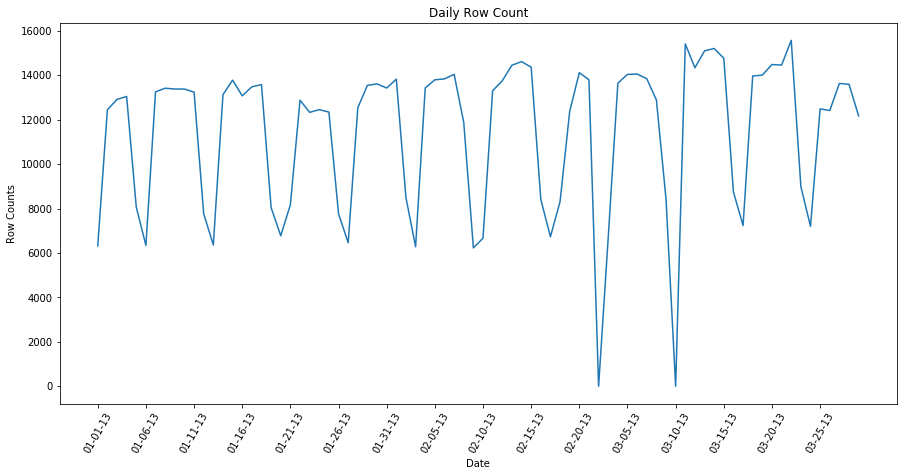

In [24]:
Q1_13_busyness = busyness_df.loc[:82]
Q1_13_busyness = Q1_13_busyness.set_index('DATE')
plt.figure(figsize=(15, 7))
plt.plot(Q1_13_busyness['BUSYNESS'])
plt.xlabel('Date')
plt.xticks(Q1_13_busyness.index[::5], rotation=60)
plt.ylabel('Row Counts')
plt.title('Daily Row Count')
plt.show()

Either ridership drops off steeply every weekend, or there is an error in my busyness function at glue points between files. The former isn't totally unreasonable, but the latter is probably more likely. This is something I'd investigate further before pushing out these results. 

The drops to 0 correspond to the files with embedded nulls that I couldn't read in.

Maybe trying to stich up all the files together into one dataframe will be better:

In [25]:
Q1_dfs = []

for file in Q1_13_csvs:
    try:
        data = get_and_parse_old_style_data(_url='http://web.mta.info/developers/'+file, 
                                            _station_dict=units_to_stations)
    except:
        continue
        
    Q1_dfs.append(data)

all_1Q_2013_data = pd.concat(Q1_dfs)

In [26]:
Q1_2013_dates = all_1Q_2013_data['DATE'].unique()
dates_ordered = sorted(pd.to_datetime(pd.Series(list(Q1_2013_dates))))
dates_ordered = [x.strftime('%m-%d-%y') for x in dates_ordered]

Q1_busyness_dict = {}

for i, date in enumerate(dates_ordered):
    if i==len(dates_ordered)-1:
        break
    try:
        start=dates_ordered[i-1]
        end=dates_ordered[i]
        end_next=dates_ordered[i+1]
    except:
        start=dates_ordered[i]
        end=dates_ordered[i+1]
        end_next=dates_ordered[i+2]

    Q1_busyness_dict[date] = get_busyness(_url=None, 
                                         _start_date=start,
                                         _end_date=end, 
                                         _next_date=end_next,
                                         _group_by=['STATION'],
                                         _final_group_by=['STATION'], 
                                         _old_style=None, 
                                         _data=all_1Q_2013_data).median()

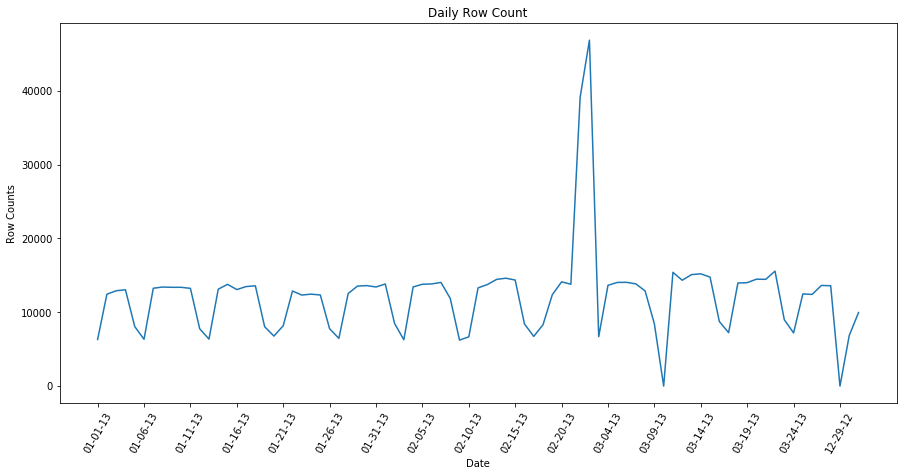

In [27]:
Q1_busyness_df=pd.DataFrame.from_dict(Q1_busyness_dict).T
Q1_busyness_df['DATE'] = Q1_busyness_df.index
Q1_busyness_df=Q1_busyness_df.reset_index()
del Q1_busyness_df['index']
pd.to_datetime(Q1_busyness_df['DATE'])
Q1_busyness_df = Q1_busyness_df.sort_values('DATE')

Q1_13_busyness_v2 = Q1_busyness_df.set_index('DATE')
plt.figure(figsize=(15, 7))
plt.plot(Q1_13_busyness_v2['BUSYNESS'])
plt.xlabel('Date')
plt.xticks(Q1_13_busyness_v2.index[::5], rotation=60)
plt.ylabel('Row Counts')
plt.title('Daily Row Count')
plt.show()

# Question 8: Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA

Gathering all Penn St. 1Q 2013 data in one dataframe to make this easier and hopefully avoid gluing problems

In [28]:
Q1_penn = all_1Q_2013_data[all_1Q_2013_data['STATION'] == '34 ST-PENN STA']
Q1_penn.head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,STATION
56752,N067,R012,00-00-00,03-23-13,00:00:00,REGULAR,323924,216389,34 ST-PENN STA
56753,N067,R012,00-00-00,03-23-13,04:00:00,REGULAR,323956,216400,34 ST-PENN STA
56754,N067,R012,00-00-00,03-23-13,04:00:00,RECOVR AUD,323956,216400,34 ST-PENN STA
56755,N067,R012,00-00-00,03-23-13,08:00:00,REGULAR,323979,216425,34 ST-PENN STA
56756,N067,R012,00-00-00,03-23-13,12:00:00,REGULAR,324080,216501,34 ST-PENN STA


In [29]:
penn_1Q_busyness_dict = {}

for i, date in enumerate(dates_ordered):
    if i==len(dates_ordered)-1:
        break
    try:
        start=dates_ordered[i-1]
        end=dates_ordered[i]
        end_next=dates_ordered[i+1]
    except:
        start=dates_ordered[i]
        end=dates_ordered[i+1]
        end_next=dates_ordered[i+2]

    penn_1Q_busyness_dict[date] = get_busyness(_url=None, 
                                                 _start_date=start,
                                                 _end_date=end, 
                                                 _next_date=end_next,
                                                 _group_by=['STATION'],
                                                 _final_group_by=['STATION'], 
                                                 _old_style=None, 
                                                 _data=Q1_penn)

In [30]:
reformatted_penn_dict = {}

for date in penn_1Q_busyness_dict:
    value = penn_1Q_busyness_dict[date].BUSYNESS[0]
    
    if value != 0.0:
        reformatted_penn_dict[date] = penn_1Q_busyness_dict[date].BUSYNESS[0]
    
jan_data = []
feb_data = []
mar_data = []

for date in reformatted_penn_dict:
    value = reformatted_penn_dict[date]
    month = date[:2]
    
    if month == '01':
        jan_data.append(value)
        
    elif month == '02':
        feb_data.append(value)
        
    elif month == '03':
        mar_data.append(value)

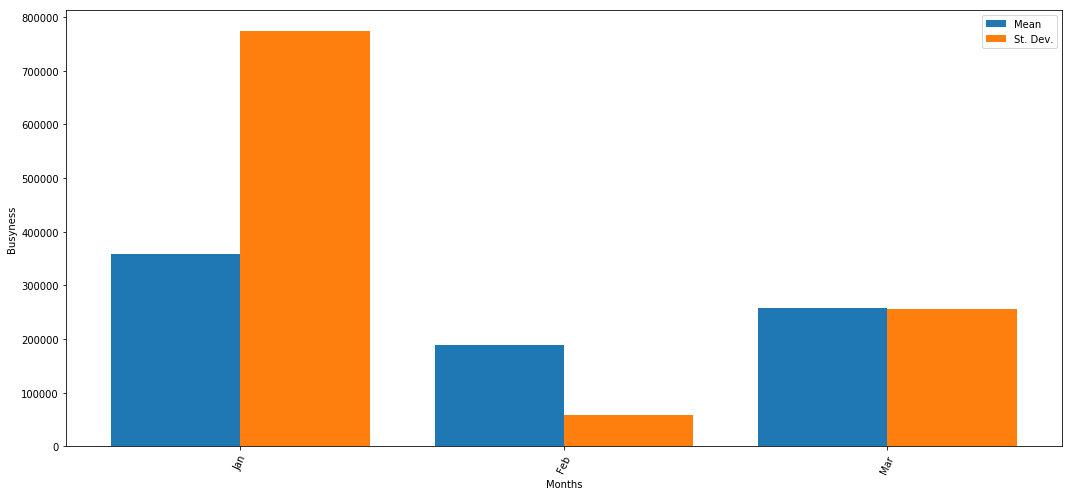

In [31]:
means = [np.mean(jan_data), np.mean(feb_data), np.mean(mar_data)]
std_devs = [np.std(jan_data), np.std(feb_data), np.std(mar_data)]
months = ['Jan', 'Feb', 'Mar']

mean = {key: val for key,val in zip(months, means)}
std = {key: val for key,val in zip(months, std_devs)}
fig, ax = plt.subplots(figsize = (15,7))
idx = np.asarray([i for i in range(len(months))])
width = 0.4
ax.bar(idx, [val for key,val in sorted(mean.items())], width=width)
ax.bar(idx+width, [val for key,val in sorted(std.items())], width=width)
ax.set_xticks(np.asarray([i+.2 for i in range(len(months))]))
ax.set_xticklabels(months, rotation=65)
ax.legend(['Mean', 'St. Dev.'])
ax.set_xlabel('Months')
ax.set_ylabel('Busyness')
fig.tight_layout()
plt.show()

# Question 9: Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA

Seems straightforward enough: using the same data above, just with quartiles instead of mean and st. dev.:

In [32]:
month_df_dict = {'Jan': jan_data, 'Feb': feb_data, 'Mar': mar_data}
first_q = []
second_q = []
third_q = []

for month in month_df_dict:
    monthly_data = month_df_dict[month]
    first_q.append(np.percentile(monthly_data, 25))
    second_q.append(np.percentile(monthly_data, 50))
    third_q.append(np.percentile(monthly_data, 75))

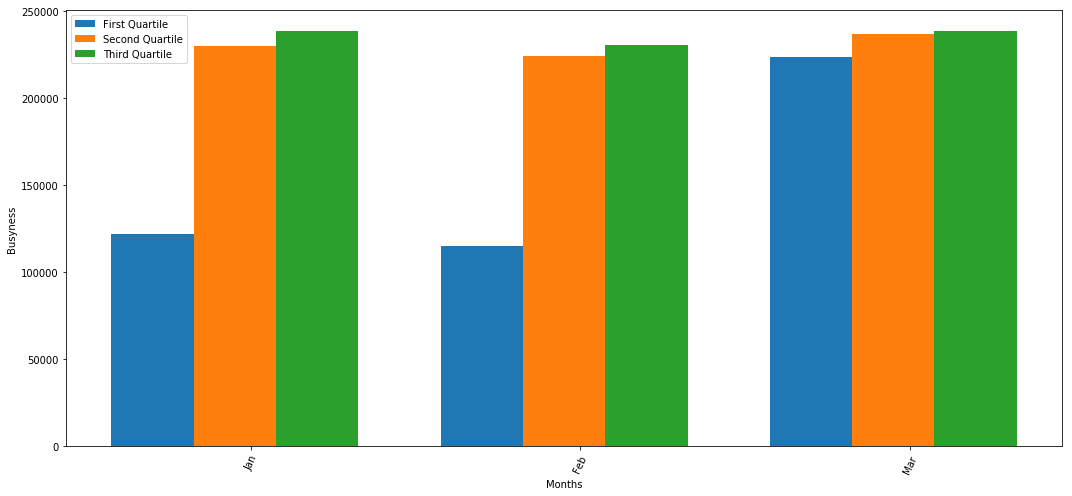

In [33]:
first = {key: val for key,val in zip(months, first_q)}
second = {key: val for key,val in zip(months, second_q)}
third = {key: val for key,val in zip(months, third_q)}
                                     
fig, ax = plt.subplots(figsize = (15,7))
idx = np.asarray([i for i in range(len(months))])
width = 0.25
ax.bar(idx, [val for key,val in sorted(first.items())], width=width)
ax.bar(idx+width, [val for key,val in sorted(second.items())], width=width)
ax.bar(idx+2*width, [val for key,val in sorted(third.items())], width=width)                                 
                                     
ax.set_xticks(np.asarray([i+.3 for i in range(len(months))]))
ax.set_xticklabels(months, rotation=65)
ax.legend(['First Quartile', 'Second Quartile', 'Third Quartile'])
ax.set_xlabel('Months')
ax.set_ylabel('Busyness')
fig.tight_layout()
plt.show()

# Question 9: Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013

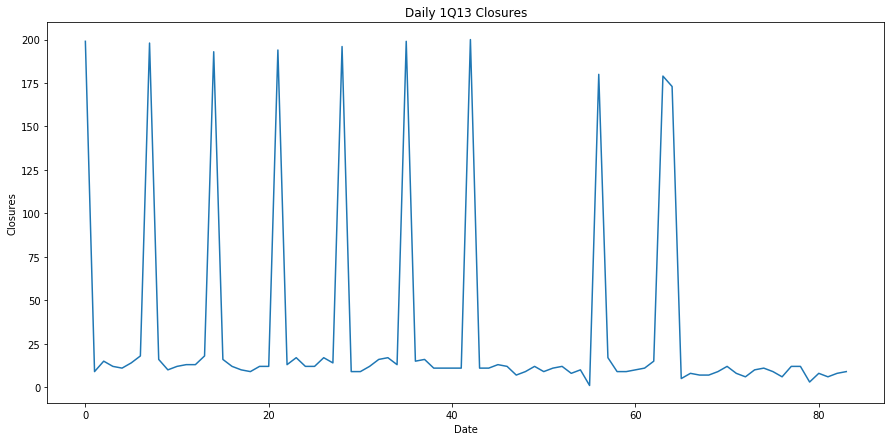

In [34]:
Q1_closures = {}

for date in dates_ordered:
    Q1_closures[date] = len(closures_dict.get(date, [0]))
    
plt.figure(figsize=(15, 7))
plt.plot(Q1_closures.values())
plt.xlabel('Date')
#plt.xticks(dates_ordered[::5], rotation=60)
plt.ylabel('Closures')
plt.title('Daily 1Q13 Closures')
plt.show()

Again, it's not unreasonable to think there are weekly spiked in closures probably on the weekends, but something seems pretty clearly off here. Most likely there is an issue with how I am computing busyness at glue points in the file. But this comes from concat'ing several dataframes into one, so there shouldn't be any gluing issues. Given more time, I'd investigate this more.

# Further:

Many of the results above make sense, but there are some issues I would investigate more before pushing to production or if I had more time. Notably, computing busyness at the glue points between files - I strongly suspect something goofy is going on there. Although, when I concat'd all the files into one dataframe, the problem persisted, so it's possible it's correct. Of course, I'd also spend more time getting the files with embeded nulls read in correctly since that was an issue. 

Another is to understand better the relationship between the fields from the schema (if this was an actual project, this would be step 0).

Finally, I'd investigate some of the specific outliers found above: why are certain busyness values several orders of magnitude greater than others? Why are we seeing negative values for daily usage in some spots? Is it simply errors when reading?